# Machine Learning Engineer Nanodegree
## Capstone
## Project- Corn Commodity Futures Price Predictor

In this project we will try to predict closing weekly price of Corn Commodity Futures. In order to perform this prediction we will create a dataset that includes weekly Corn Futures closing prices as well as Long Open Interest and Short Open Interest of Processors/Users( sometimes they are called Commercials) from COT reports and by using this dataset we will try to predict next week’s prices. 


## 1. Data Sets

Historical Futures Prices: Corn Futures, Continuous Contract #1. Non-adjusted price based on spot-month continuous contract calculations. Raw data from CME:
[Can be found here](https://www.quandl.com/data/CHRIS/CME_C1-Corn-Futures-Continuous-Contract-1-C1-Front-Month)<br>
Commitment of Traders - CORN (CBT) - Futures Only (002602)
[Can be found here](https://www.quandl.com/data/CFTC/002602_F_ALL-Commitment-of-Traders-CORN-CBT-Futures-Only-002602)

Data has been downloaded and stored in \Data folder:

- **.\data\CHRIS-CME_C1.csv** - Corn Futures Prices data
- **.\data\CFTC-002602_F_ALL.csv** - Commitment of Traders data


In [56]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
pd.options.display.max_colwidth = 500  # You need this, otherwise pandas
# will limit your HTML strings to 50 characters
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
from matplotlib import pyplot

## 2. Data Exploration



In [45]:
df_fut_orig = pd.read_csv('data\CHRIS-CME_C1.csv')
df_fut_orig.head(n=5)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous_Day_Open_Interest
0,2018-07-10,344.25,344.75,336.25,339.50,6.00,339.75,2668.0,2186.0
1,2018-07-09,346.00,348.50,342.50,346.00,6.00,345.75,3190.0,2969.0
2,2018-07-06,342.00,352.25,342.00,350.75,8.25,351.75,3068.0,3959.0
3,2018-07-05,345.50,348.75,341.50,342.50,0.75,343.50,3302.0,4812.0
4,2018-07-03,340.25,345.25,339.25,343.25,5.25,342.75,3048.0,5687.0


In [46]:
df_cot_orig = pd.read_csv('data\CFTC-002602_F_ALL.csv')
df_cot_orig.head()

,Date,Open Interest,Producer_Merchant_Processor_User_Longs,Producer_Merchant_Processor_User_Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
0,2018-07-10,1818055.0,500172.0,750062.0,208128.0,39513.0,99477.0,263353.0,404297.0,154286.0,320946.0,70682.0,98709.0,1645071.0,1617026.0,172984.0,201029.0
1,2018-07-03,1830330.0,484257.0,773851.0,210341.0,36927.0,100340.0,274795.0,382191.0,149756.0,322256.0,66508.0,119627.0,1661372.0,1629200.0,168958.0,201130.0
2,2018-06-26,1885804.0,513100.0,840177.0,223131.0,32763.0,91972.0,287061.0,377825.0,153461.0,330396.0,58283.0,116745.0,1715866.0,1671226.0,169938.0,214578.0
3,2018-06-19,1992169.0,525197.0,920764.0,222105.0,41144.0,99285.0,299377.0,356828.0,163454.0,379025.0,56652.0,135078.0,1823521.0,1773205.0,168648.0,218964.0
4,2018-06-12,1963233.0,488666.0,917204.0,235249.0,37674.0,93281.0,292054.0,304292.0,172623.0,363918.0,65030.0,147098.0,1792889.0,1737202.0,170344.0,226031.0


### Drop unnecessary columns columns and resample data

In [47]:
df_fut=df_fut_orig.drop(columns=[clmn for i,clmn in enumerate(df_fut_orig.columns) if i not in [0,1,6,7] ],axis=1)

df_fut['Date'] = pd.to_datetime(df_fut['Date'])
df_fut.set_index('Date',inplace=True)

df_fut.head()

,Open,Settle,Volume
Date,,,
2018-07-10,344.25,339.75,2668.0
2018-07-09,346.00,345.75,3190.0
2018-07-06,342.00,351.75,3068.0
2018-07-05,345.50,343.50,3302.0
2018-07-03,340.25,342.75,3048.0


In [48]:
s_open =df_fut['Open'].resample('W').first()
s_settle =df_fut['Settle'].resample('W').last()
s_volume =df_fut['Volume'].resample('W').last()
df_fut_weekly = pd.concat([s_open, s_settle,s_volume], axis=1)
df_fut_weekly.head()

,Open,Settle,Volume
Date,,,
2006-06-18,234.00,235.50,56486.0
2006-06-25,234.00,228.25,28361.0
2006-07-02,227.00,235.50,30519.0
2006-07-09,239.25,241.00,13057.0
2006-07-16,246.50,253.50,2460.0


In [52]:
df_cot=df_cot_orig.drop(columns=[clmn for i,clmn in enumerate(df_cot_orig.columns) if i not in [0,2,3 ]],axis=1)
df_cot.rename(index=str, columns={"Producer_Merchant_Processor_User_Longs": "Longs", \
                                  "Producer_Merchant_Processor_User_Shorts": "Shorts"},inplace=True)
df_cot['Date'] = pd.to_datetime(df_cot['Date'])
df_cot.set_index('Date',inplace=True)
df_cot.head()

,Longs,Shorts
Date,,
2018-07-10,500172.0,750062.0
2018-07-03,484257.0,773851.0
2018-06-26,513100.0,840177.0
2018-06-19,525197.0,920764.0
2018-06-12,488666.0,917204.0


In [53]:
s_longs =df_cot['Longs'].resample('W').last()
s_shorts =df_cot['Shorts'].resample('W').last()
df_cot_weekly = pd.concat([s_longs, s_shorts], axis=1)
df_cot_weekly.head()

,Longs,Shorts
Date,,
2006-06-18,209662.0,699163.0
2006-06-25,224476.0,666688.0
2006-07-02,234769.0,645735.0
2006-07-09,220552.0,648405.0
2006-07-16,216968.0,673110.0


In [55]:
df_weekly = pd.merge(df_fut_weekly,df_cot_weekly, on='Date')
df_weekly.head()


,Open,Settle,Volume,Longs,Shorts
Date,,,,,
2006-06-18,234.00,235.50,56486.0,209662.0,699163.0
2006-06-25,234.00,228.25,28361.0,224476.0,666688.0
2006-07-02,227.00,235.50,30519.0,234769.0,645735.0
2006-07-09,239.25,241.00,13057.0,220552.0,648405.0
2006-07-16,246.50,253.50,2460.0,216968.0,673110.0


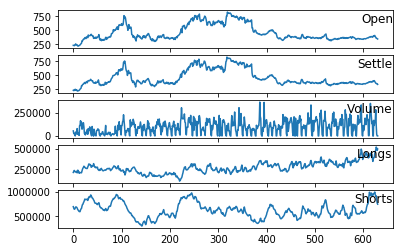

In [59]:
values = df_weekly.values
# specify columns to plot
groups = [0, 1, 2, 3,4 ]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df_weekly.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [23]:
df_fut.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3034 entries, 2018-07-10 to 2006-06-16
Data columns (total 3 columns):
Open      3033 non-null float64
Settle    3034 non-null float64
Volume    3034 non-null float64
dtypes: float64(3)
memory usage: 94.8 KB


In [1]:
import pandas as pd
import numpy as np

fut_data = pd.read_csv('data\CHRIS-CME_C1.csv')
print(fut_data.head())

print("\n")
print("Open   --- mean :", np.mean(data['Open']),  "  \t Std: ", np.std(data['Open']),  "  \t Max: ", np.max(data['Open']),  "  \t Min: ", np.min(data['Open']))
print("High   --- mean :", np.mean(data['High']),  "  \t Std: ", np.std(data['High']),  "  \t Max: ", np.max(data['High']),  "  \t Min: ", np.min(data['High']))
print("Low    --- mean :", np.mean(data['Low']),   "  \t Std: ", np.std(data['Low']),   "  \t Max: ", np.max(data['Low']),   "  \t Min: ", np.min(data['Low']))
print("Close  --- mean :", np.mean(data['Close']), "  \t Std: ", np.std(data['Close']), "  \t Max: ", np.max(data['Close']), "  \t Min: ", np.min(data['Close']))
print("Volume --- mean :", np.mean(data['Volume']),"  \t Std: ", np.std(data['Volume']),"  \t Max: ", np.max(data['Volume']),"  \t Min: ", np.min(data['Volume']))


NameError: name 'data' is not defined

**Step 2 :** Remove Unncessary data, i.e., Date and High value

In [37]:
import preprocess_data as ppd
stocks = ppd.remove_data(data)

#Print the dataframe head and tail
print(stocks.head())
print("---")
print(stocks.tail())

   Item    Open   Close    Volume
0     0   98.80  101.46  15860692
1     1  100.77   97.35  13762396
2     2   96.82   96.85   8239545
3     3   97.72   94.37  10389803
4     4   95.42   97.02   9666175
---
      Item    Open   Close   Volume
3140  3140  990.00  972.09  1517912
3141  3141  961.60  948.09  2443602
3142  3142  950.66  961.01  2745568
3143  3143  951.35  937.82  3206674
3144  3144  943.99  929.68  2287662


**Step 2: ** Visualise raw data.

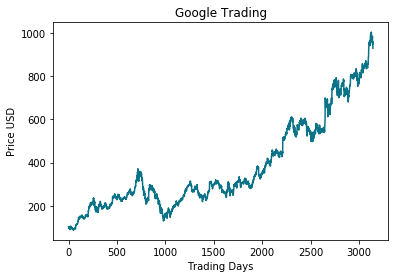

In [38]:
import visualize

visualize.plot_basic(stocks)

**Step 3 :** Normalise the data using minmaxscaler function

In [39]:
stocks = ppd.get_normalised_data(stocks)
print(stocks.head())

print("\n")
print("Open   --- mean :", np.mean(stocks['Open']),  "  \t Std: ", np.std(stocks['Open']),  "  \t Max: ", np.max(stocks['Open']),  "  \t Min: ", np.min(stocks['Open']))
print("Close  --- mean :", np.mean(stocks['Close']), "  \t Std: ", np.std(stocks['Close']), "  \t Max: ", np.max(stocks['Close']), "  \t Min: ", np.min(stocks['Close']))
print("Volume --- mean :", np.mean(stocks['Volume']),"  \t Std: ", np.std(stocks['Volume']),"  \t Max: ", np.max(stocks['Volume']),"  \t Min: ", np.min(stocks['Volume']))

   Item      Open     Close    Volume
0     0  0.012051  0.015141  0.377248
1     1  0.014198  0.010658  0.325644
2     2  0.009894  0.010112  0.189820
3     3  0.010874  0.007407  0.242701
4     4  0.008368  0.010298  0.224905


Open   --- mean : 0.3211922293886812   	 Std:  0.23261946808306658   	 Max:  0.9999999999999999   	 Min:  0.0
Close  --- mean : 0.3215558503465895   	 Std:  0.23283076112482215   	 Max:  1.0   	 Min:  0.0
Volume --- mean : 0.09061506381049182   	 Std:  0.09535947661989863   	 Max:  0.9999999999999999   	 Min:  0.0


**Step 4 :** Visualize the data again

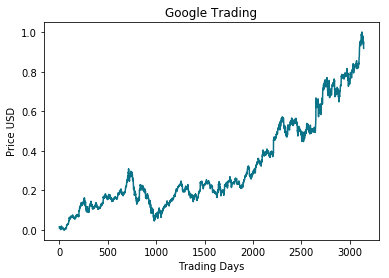

In [40]:
visualize.plot_basic(stocks)

**Step 5:** Log the normalised data for future resuablilty

In [41]:
stocks.to_csv('google_preprocessed.csv',index= False)

# Check Point #2

This is my second checkpoint. The preprocessed data has been saved to disk.

## Bench Mark Model

In this section we will check our bench mark model. As is proposed in my proposal my bench mark model is a simple linear regressor model. 

**Step 1:** Load the preprocessed data

In [42]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import visualize as vs
import stock_data as sd
import LinearRegressionModel

stocks = pd.read_csv('google_preprocessed.csv')
display(stocks.head())

,Item,Open,Close,Volume
0,0,0.012051,0.015141,0.377248
1,1,0.014198,0.010658,0.325644
2,2,0.009894,0.010112,0.189820
3,3,0.010874,0.007407,0.242701
4,4,0.008368,0.010298,0.224905


**Step 2:** Split data into train and test pair

In [43]:
X_train, X_test, y_train, y_test, label_range= sd.train_test_split_linear_regression(stocks)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2155, 1)
y_train (2155, 1)
x_test (990, 1)
y_test (990, 1)


**Step 3:** Train a Linear regressor model on training set and get prediction

In [44]:
model = LinearRegressionModel.build_model(X_train,y_train)

**Step 4:** Get prediction on test set

In [45]:
predictions = LinearRegressionModel.predict_prices(model,X_test, label_range)

**Step 5:** Plot the predicted values against actual

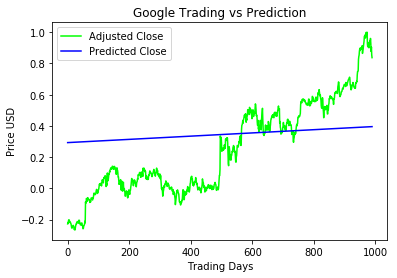

In [46]:
vs.plot_prediction(y_test,predictions)

**Step 6:** measure accuracy of the prediction

In [47]:
trainScore = mean_squared_error(X_train, y_train)
print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = mean_squared_error(predictions, y_test)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.1852 MSE (0.4303 RMSE)
Test Score: 0.08133781 MSE (0.28519784 RMSE)


# Checkpoint #3


## Long-Sort Term Memory Model

In this section we will use LSTM to train and test on our data set.

### Basic LSTM Model

First lets make a basic LSTM model.

**Step 1 :** import keras libraries for smooth implementaion of lstm 

In [48]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import lstm, time #helper libraries

import visualize as vs
import stock_data as sd
import LinearRegressionModel

stocks = pd.read_csv('google_preprocessed.csv')
stocks_data = stocks.drop(['Item'], axis =1)

display(stocks_data.head())

,Open,Close,Volume
0,0.012051,0.015141,0.377248
1,0.014198,0.010658,0.325644
2,0.009894,0.010112,0.189820
3,0.010874,0.007407,0.242701
4,0.008368,0.010298,0.224905


**Step 2 :** Split train and test data sets and Unroll train and test data for lstm model

In [49]:
X_train, X_test,y_train, y_test = sd.train_test_split_lstm(stocks_data, 5)

unroll_length = 50
X_train = sd.unroll(X_train, unroll_length)
X_test = sd.unroll(X_test, unroll_length)
y_train = y_train[-X_train.shape[0]:]
y_test = y_test[-X_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2589, 50, 3)
y_train (2589,)
x_test (446, 50, 3)
y_test (446,)


C:\udacity\capstone\other_people\rajat\Stock-Price-Predictor-master\stock_data.py:79: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_train = stocks[0:-prediction_time - test_data_cut].as_matrix()
C:\udacity\capstone\other_people\rajat\Stock-Price-Predictor-master\stock_data.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_train = stocks[prediction_time:-test_data_cut]['Close'].as_matrix()
C:\udacity\capstone\other_people\rajat\Stock-Price-Predictor-master\stock_data.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  x_test = stocks[0 - test_data_cut:-prediction_time].as_matrix()
C:\udacity\capstone\other_people\rajat\Stock-Price-Predictor-master\stock_data.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  y_test = stocks[prediction_time - test_data_cut:]['Close'].as_matrix()


**Step 3 :** Build a basic Long-Short Term Memory model

In [50]:
# build basic lstm model
model = lstm.build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.030002593994140625


**Step 4:** Train the model

In [51]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)

Train on 2459 samples, validate on 130 samples
Epoch 1/1
2459/2459 [==============================] - 6s 2ms/step - loss: 0.0041 - val_loss: 2.8666e-04


**Step 5:** make prediction using test data

In [52]:
predictions = model.predict(X_test)

**Step 6:** Plot the results

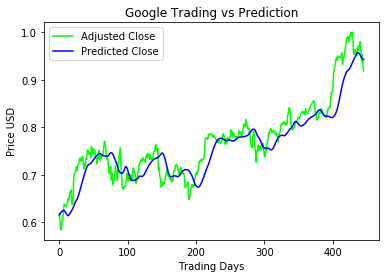

In [53]:
vs.plot_lstm_prediction(y_test,predictions)

** Step 7:** Get the test score.

In [54]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00034886 MSE (0.01867783 RMSE)
Test Score: 0.00115569 MSE (0.03399540 RMSE)


### Improved LSTM Model

**Step 1: ** Build an improved LSTM model

In [55]:
# Set up hyperparameters
batch_size = 100
epochs = 5

# build improved lstm model
model = lstm.build_improved_model( X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
#final_model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.023999452590942383


**Step 2: ** Train improved LSTM model

In [56]:
model.fit(X_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Train on 2459 samples, validate on 130 samples
Epoch 1/5
 - 5s - loss: 0.0108 - val_loss: 0.0020
Epoch 2/5
 - 3s - loss: 0.0011 - val_loss: 0.0015
Epoch 3/5
 - 3s - loss: 8.0022e-04 - val_loss: 3.7125e-04
Epoch 4/5
 - 3s - loss: 6.6364e-04 - val_loss: 3.1677e-04
Epoch 5/5
 - 3s - loss: 6.3024e-04 - val_loss: 3.0656e-04


**Step 3:** Make prediction on improved LSTM model

In [57]:
# Generate predictions 
predictions = model.predict(X_test, batch_size=batch_size)

**Step 4:** plot the results

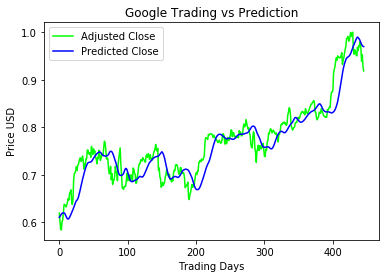

In [58]:
vs.plot_lstm_prediction(y_test,predictions)

**Step 5:** Get the test score

In [59]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00032527 MSE (0.01803536 RMSE)
Test Score: 0.00098477 MSE (0.03138103 RMSE)


In [60]:
range = [np.amin(stocks_data['Close']), np.amax(stocks_data['Close'])]

#Calculate the stock price delta in $

true_delta = testScore*(range[1]-range[0])
print('Delta Price: %.6f - RMSE * Adjusted Close Range' % true_delta)    

Delta Price: 0.000985 - RMSE * Adjusted Close Range


# Checking Robustness of the model

In this section we will check robustness of our LSTM model. I have used new unseen datasets for this from July 1, 2017 to July 20,2017. I have downloaded the data sets from google finance website to check for robustness of the model.

In [61]:
import preprocess_data as ppd

data = pd.read_csv('googl.csv')

stocks = ppd.remove_data(data)

stocks = ppd.get_normalised_data(stocks)

stocks = stocks.drop(['Item'], axis = 1)
#Print the dataframe head and tail
print(stocks.head())

X = stocks[:].as_matrix()
Y = stocks[:]['Close'].as_matrix()

X = sd.unroll(X,1)
Y = Y[-X.shape[0]:]

print(X.shape)
print(Y.shape)

# Generate predictions 
predictions = model.predict(X)

#get the test score
testScore = model.evaluate(X, Y, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

       Open     Close    Volume
0  0.123901  0.000000  0.606442
1  0.000000  0.174601  1.000000
2  0.010989  0.112263  0.921928
3  0.093132  0.291229  0.575381
4  0.243819  0.430228  0.366556
(12, 1, 3)
(12,)
Test Score: 0.3922 MSE (0.6262 RMSE)


C:\Users\MarozasZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
C:\Users\MarozasZ\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
